In [1]:
import onnx
import torch

import numpy as np
import cv2
import os
import struct
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
from random import randrange
import copy

## Load dataset

print("Loading dataset")

one_img_dir = "/home/nm/Downloads/VOCdevkit/VOC2012/single_or_no_person_dataset/single_person_images"
one_txt_dir = "/home/nm/Downloads/VOCdevkit/VOC2012/single_or_no_person_dataset/single_person_txt"


train_images = []
train_labels = []
test_images = []
test_labels = []

temp_label = []


# ---------------------------------#

orig_img_size = 500
global resized_size
resized_size = 256

color = 1 ## 1 = color, 0 = grayscale

# ---------------------------------#

dims = (resized_size, resized_size) # dimensions of images to train/test with

label_scale = dims[0] / orig_img_size # resize label to fit resized image

## KEEP IN MIND GRAYSCALE, INCLUDE COLORS (3x channels) 

num_test = 0
num_train = 0

read_folder = one_img_dir + '/'
label_folder = one_txt_dir + '/'

for filename in os.listdir(read_folder):
    sample_dataset = randrange(10)
    if sample_dataset > -1:#== 0:
        randint = randrange(20)
        img = cv2.imread(os.path.join(read_folder,filename),color) # read img as grayscale
        img = cv2.resize(img, dims, interpolation = cv2.INTER_AREA)# resize img to fit dims
        if color == 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
        f = open(label_folder + filename.replace('.jpg','.txt'), "r")
        temp_label = (f.read().split(","))
        for k in range (4):
            temp_label[k] = round(float(temp_label[k]) * label_scale)
        f.close()       
        #temp_label_oh = to_onehot(temp_label, (dims[0]/10), dims[0])

        if img is not None:
            if randint > 1:
                train_images.append(np.asarray(img/255).astype('float32'))
                train_labels.append(np.asarray(temp_label).astype('float32'))
                num_train += 1   

            if randint < 2:
                test_images.append(np.asarray(img/255).astype('float32'))
                test_labels.append(np.asarray(temp_label).astype('float32'))
                num_test += 1

                  
print("Finished loading dataset: ", num_train, " train images and ", num_test, " test images")

Loading dataset
Finished loading dataset:  4943  train images and  557  test images


In [2]:
import random

def to_onehot(label, n_categories, img_dim):
    n_categories = round(n_categories)
    one_hot_label = np.zeros(n_categories*4) # 4 = num classes, concat'ed multihot vector
    scaling = float(n_categories) / float(img_dim)
    for i in range(len(label)):
        # indexing starts at 1 and tensor indexing starts at 0
        label_scaled = round(label[i] * scaling)
        if label_scaled > (n_categories-1):
            label_scaled = n_categories-1
        if label_scaled < 0:
            label_scaled = 0
        one_hot_label[(label_scaled+(n_categories*i))] = float(1.0) ## -1?
    return one_hot_label


def shift_image(img,tx,ty):  
    tmp_img = copy.deepcopy(img)
    num_rows, num_cols = tmp_img.shape[:2]
    # Creating a translation matrix
    translation_matrix = np.float32([ [1,0,tx], [0,1,ty] ])
    # Image translation
    img_translation = cv2.warpAffine(tmp_img, translation_matrix, (num_cols,num_rows))
    #print("shifted ", tx, " x, ", ty, " y")
    return img_translation


def shift_img_label(img, label, tx, ty):
    shifted_image = shift_image(img, tx, ty)
    shifted_label = copy.deepcopy(label)
    shifted_label[0] = shifted_label[0] + tx
    shifted_label[1] = shifted_label[1] + ty
    shifted_label[2] = shifted_label[2] + tx
    shifted_label[3] = shifted_label[3] + ty
    return shifted_image, shifted_label


def xyshift_img_label(direction, image, label):
    #direction 0..7: -y, x-y, x, xy, y, -xy, -x, -x-y
    img = copy.deepcopy(image)        
    temp_label = copy.deepcopy(label)
        
    if direction == 0:
        randshift_x = 0
        randshift_y = -1 * randrange(round((resized_size*0.05)), (temp_label[1]))
    if direction == 1:
        randshift_x = randrange(round((resized_size*0.05)), (resized_size-temp_label[2]))
        randshift_y = -1 * randrange(round((resized_size*0.05)), (temp_label[1]))
    if direction == 2:
        randshift_x = randrange(round((resized_size*0.05)), (resized_size-temp_label[2]))
        randshift_y = 0
    if direction == 3:
        randshift_x = randrange(round((resized_size*0.05)), (resized_size-temp_label[2]))
        randshift_y = randrange(round((resized_size*0.05)), (resized_size-temp_label[3]))
    if direction == 4:
        randshift_x = 0
        randshift_y = randrange(round((resized_size*0.05)), (resized_size-temp_label[3]))
    if direction == 5:
        randshift_x = -1 * randrange(round((resized_size*0.05)), (temp_label[0]))
        randshift_y = randrange(round((resized_size*0.05)), (resized_size-temp_label[3]))
    if direction == 6:
        randshift_x = -1 * randrange(round((resized_size*0.05)), (temp_label[0]))
        randshift_y = 0
    if direction == 7:
        randshift_x = -1 * randrange(round((resized_size*0.05)), (temp_label[0]))
        randshift_y = -1 * randrange(round((resized_size*0.05)), (temp_label[1]))
        
    img, temp_label = shift_img_label(img, temp_label, randshift_x, randshift_y)
    
    return img, temp_label


def augment(image, label):
    # Randomly augment input:
    # -Mirror, xy-shift, brightness, noise, blur, color shift 

    img = copy.deepcopy(image)
    temp_label = copy.deepcopy(label)
    
    mirror = random.randrange(2)
    if mirror == 1:
        img = cv2.flip(img, 1)

    if mirror == 1:
        tmp_lab = (resized_size-temp_label[0])
        temp_label[0] = (resized_size-temp_label[2])
        temp_label[2] = tmp_lab
        #print("mirrored")

    
    xyshift = random.randrange(4)
    possible_shifts = [0,0,0,0,0,0,0,0] #-y, x-y, x, xy, y, -xy, -x, -x-y
    if xyshift > 0: # check which shifts are possible first
        if temp_label[0] > (resized_size*0.1): # check -x
            possible_shifts[6] = 2
            possible_shifts[7] += 1 ## works?
            possible_shifts[5] += 1
        if temp_label[1] > (resized_size*0.1): # check -y
            possible_shifts[0] = 2
            possible_shifts[1] += 1
            possible_shifts[7] += 1
        if temp_label[2] < (resized_size - (resized_size*0.1)): # check +x
            possible_shifts[2] = 2
            possible_shifts[1] += 1
            possible_shifts[3] += 1
        if temp_label[3] < (resized_size - (resized_size*0.1)): # check +y
            possible_shifts[4] = 2
            possible_shifts[5] += 1
            possible_shifts[3] += 1
            
        num_possible = possible_shifts.count(2)
        random_shift_pick = random.randrange(num_possible)
        its = 0
        for i in range(len(possible_shifts)):
            if possible_shifts[i] == 2:
                its += 1
            if its == random_shift_pick and possible_shifts[i] == 2:
                img, temp_label = xyshift_img_label(i, img, temp_label)
                
                   
    blur = random.randrange(2)
    if blur == 1:
        img = cv2.blur(img,(3, 3))
        #print("blurred")
        
    brightness = random.randrange(2)
    if brightness == 1:
        img_tmp  = np.asarray(img*255).astype("uint8")
        bright = np.ones(img.shape, dtype="uint8") * random.randrange(30,80)
        if random.randrange(2) == 1: # brighten
            img = np.asarray(cv2.add(img_tmp, bright)).astype("float32")/255
            #print("brighten")
        else: # darken
            img = np.asarray(cv2.subtract(img_tmp, bright)).astype("float32")/255
            #print("darken")
    
    
    color_shift = random.randrange(2)
    if color_shift == 1:
        rows, cols = img.shape[:2]
        img = np.float32(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # transform to HSV color space .
        h, s, v = cv2.split(img) # split each channel in order to add seperate range of values to each channel.
        h += np.random.randint(0, 50,size=(rows, cols), dtype=np.uint8 )
        s += np.random.randint(0, 1,size=(rows, cols), dtype=np.uint8 )
        v += np.random.randint(0, 1,size=(rows, cols) , dtype=np.uint8 )
        img = cv2.merge([h,s,v ])
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        img = img.astype("float32")
        #print("color shifted")
        
    #if mirror == 0 and xyshift == 0 and color_shift == 0 and blur == 0 and brightness == 0:
    #    print("original")
        
    return img, temp_label


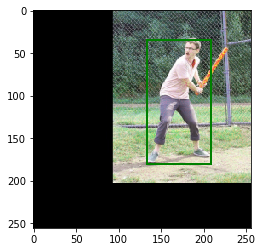

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#print(train_labels_batches[0][0])

im, label = augment(train_images[0], train_labels[0])
#im, label = augment(train_images_batches[0][0], train_labels_batches[0][0])

xmin_targ = int(label[0])
ymin_targ = int(label[1])
xmax_targ = int(label[2])
ymax_targ = int(label[3])

# Create figure and axes
fig, ax = plt.subplots()
# Display the image
ax.imshow(im)
# Create a Rectangle patch
targ_rect = patches.Rectangle((xmin_targ,ymin_targ), abs(xmax_targ-xmin_targ), abs(ymax_targ-ymin_targ), linewidth=2, edgecolor='g', facecolor='none')
# Add the patch to the Axes
ax.add_patch(targ_rect)

plt.show()

In [4]:
print("Creating test dataloader..")
test_images = np.asarray(test_images).astype('float32')
test_images = np.moveaxis(np.asarray(test_images),-1,1)
test_labels = np.asarray(test_labels).astype('float32')


print(np.shape(test_images))

# dataset loaders
global batch_size
batch_size = 40

inputs  = torch.unsqueeze(torch.from_numpy(test_images).clone().detach(), 1)
targets = torch.from_numpy(test_labels).clone().detach().type(torch.FloatTensor)
dataset = TensorDataset(inputs, targets)
test_quantized_loader = DataLoader(dataset, batch_size, shuffle = True)

count = 0
for x,y in test_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    break
        
print("Test dataloader created")

print("Creating training batches..")

import math
        
def divide_batches_imgs(nparray, batch_size):
    shape = [math.floor(nparray.shape[0] / batch_size), batch_size, nparray.shape[1], nparray.shape[2], nparray.shape[3]]
    tmp_array = np.empty(shape)
    for i in range(0, nparray.shape[0], batch_size):
        if  math.floor(i/batch_size) == math.floor(nparray.shape[0] / batch_size):
            break
        #print(i, math.floor(i/batch_size))
        tmp_array[math.floor(i/batch_size)] = nparray[i:i + batch_size]
        
    return tmp_array


def divide_batches_labels(nparray, batch_size):
    shape = [math.floor(nparray.shape[0] / batch_size), batch_size, nparray.shape[1]]
    tmp_array = np.empty(shape)
    for i in range(0, nparray.shape[0], batch_size):
        if  math.floor(i/batch_size) == math.floor(nparray.shape[0] / batch_size):
            break
        #print(i, math.floor(i/batch_size))
        tmp_array[math.floor(i/batch_size)] = nparray[i:i + batch_size]
        
    return tmp_array


train_images = np.asarray(train_images).astype('float32')
train_labels = np.asarray(train_labels).astype('float32')

        
from sklearn.utils import shuffle

#train_images, train_labels = shuffle(train_images, train_labels)
#train_images_batches = divide_batches_imgs(train_images, batch_size)
#train_labels_batches = divide_batches_labels(train_labels, batch_size)

#del test_images
#del test_labels
#del train_images
#del train_labels

#print("Train images shape: ", np.shape(train_images_batches))
#print("Train labels shape: ", np.shape(train_labels_batches))
#print("Training batches created")

Creating test dataloader..
(557, 3, 256, 256)
Input shape for 1 batch: torch.Size([40, 1, 3, 256, 256])
Label shape for 1 batch: torch.Size([40, 4])
Test dataloader created
Creating training batches..


In [5]:
# MIT License
#
# Copyright (c) 2019 Xilinx
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

import torch
from torch.nn import Module, ModuleList, BatchNorm2d, MaxPool2d, BatchNorm1d

from brevitas.nn import QuantConv2d, QuantIdentity, QuantLinear
from brevitas.core.restrict_val import RestrictValueType
from models.tensor_norm import TensorNorm
from models.common import CommonWeightQuant, CommonActQuant

#---------------------------------------------------------------------------------
CNV_OUT_CH_POOL = [(64, True), (64, True), (128, True), (128, True), (256, True), (256, True), (256, True)]
#---------------------------------------------------------------------------------
LAST_CNV_OUT = CNV_OUT_CH_POOL[-1][0]
NUM_MPOOLS = [item for sublist in CNV_OUT_CH_POOL for item in sublist].count(True)
LAST_CNV_FEATURES = int(LAST_CNV_OUT * pow((dims[0] / pow(2,NUM_MPOOLS)),2))
#----------------------------------------------------------------
INTERMEDIATE_FC_FEATURES = [(LAST_CNV_FEATURES, 256), (256, 256)]
#----------------------------------------------------------------
LAST_FC_IN_FEATURES = INTERMEDIATE_FC_FEATURES[-1][-1]
LAST_FC_PER_OUT_CH_SCALING = False
POOL_SIZE = 2
KERNEL_SIZE = 3


class CNV(Module):

    def __init__(self, num_classes, weight_bit_width, act_bit_width, in_bit_width, in_ch):
        super(CNV, self).__init__()

        self.conv_features = ModuleList()
        self.linear_features = ModuleList()

        self.conv_features.append(QuantIdentity( # for Q1.7 input format
            act_quant=CommonActQuant,
            bit_width=in_bit_width,
            min_val=- 1.0,
            max_val=1.0 - 2.0 ** (-7),
            narrow_range=False,
            restrict_scaling_type=RestrictValueType.POWER_OF_TWO))

        for out_ch, is_pool_enabled in CNV_OUT_CH_POOL:
            self.conv_features.append(QuantConv2d(
                kernel_size=KERNEL_SIZE,
                in_channels=in_ch,
                out_channels=out_ch,
                bias=False,
                padding=1, 
                groups=1,
                weight_quant=CommonWeightQuant,
                weight_bit_width=weight_bit_width))
            in_ch = out_ch
            self.conv_features.append(BatchNorm2d(in_ch, eps=1e-4))
            self.conv_features.append(QuantIdentity(
                act_quant=CommonActQuant,
                bit_width=act_bit_width))
            if is_pool_enabled:
                self.conv_features.append(MaxPool2d(kernel_size=2))

        for in_features, out_features in INTERMEDIATE_FC_FEATURES:
            self.linear_features.append(QuantLinear(
                in_features=in_features,
                out_features=out_features,
                bias=False,
                weight_quant=CommonWeightQuant,
                weight_bit_width=weight_bit_width))
            self.linear_features.append(BatchNorm1d(out_features, eps=1e-4))
            self.linear_features.append(QuantIdentity(
                act_quant=CommonActQuant,
                bit_width=act_bit_width))

        self.linear_features.append(QuantLinear(
            in_features=LAST_FC_IN_FEATURES,
            out_features=num_classes,
            bias=False,
            weight_quant=CommonWeightQuant,
            weight_bit_width=weight_bit_width))
        self.linear_features.append(TensorNorm())
        
        for m in self.modules():
            if isinstance(m, QuantConv2d) or isinstance(m, QuantLinear):
                torch.nn.init.uniform_(m.weight.data, -1, 1)


    def clip_weights(self, min_val, max_val):
        for mod in self.conv_features:
            if isinstance(mod, QuantConv2d):
                mod.weight.data.clamp_(min_val, max_val)
        for mod in self.linear_features:
            if isinstance(mod, QuantLinear):
                mod.weight.data.clamp_(min_val, max_val)

    def forward(self, x):
        x = 2.0 * x - torch.tensor([1.0], device=x.device)
        for mod in self.conv_features:
            x = mod(x)
        x = x.view(x.shape[0], -1)
        for mod in self.linear_features:
            x = mod(x)
        return x


def cnv(cfg):
    weight_bit_width = cfg.getint('QUANT', 'WEIGHT_BIT_WIDTH')
    act_bit_width = cfg.getint('QUANT', 'ACT_BIT_WIDTH')
    in_bit_width = cfg.getint('QUANT', 'IN_BIT_WIDTH')
    num_classes = cfg.getint('MODEL', 'NUM_CLASSES')
    in_channels = cfg.getint('MODEL', 'IN_CHANNELS')
    net = CNV(weight_bit_width=weight_bit_width,
              act_bit_width=act_bit_width,
              in_bit_width=in_bit_width,
              num_classes=num_classes,
              in_ch=in_channels)
    return net

NUM_CLASSES = num_classes =  round((dims[0]/10))*4 #10
WEIGHT_BIT_WIDTH = 1
ACT_BIT_WIDTH = 1
IN_BIT_WIDTH = 8
IN_CHANNELS = 3

cnv_model = CNV(NUM_CLASSES, WEIGHT_BIT_WIDTH, ACT_BIT_WIDTH, IN_BIT_WIDTH, IN_CHANNELS)




#test forward pass
it = iter(test_quantized_loader)
x,y = next(it)

x = torch.squeeze(x, 1)
outp = cnv_model(x)

print(outp)

tensor([[-0.6013, -0.3543,  0.5101,  ..., -0.4778, -1.0952, -0.4778],
        [ 0.1396, -1.3422, -0.4778,  ..., -0.4778,  0.1396,  0.0161],
        [ 1.4980, -0.4778,  1.1275,  ..., -0.3543, -0.9718, -1.3422],
        ...,
        [ 0.8806, -0.1073,  0.2631,  ..., -0.7248, -1.0952,  1.7450],
        [ 0.6336, -0.6013, -0.4778,  ...,  0.7571, -0.6013,  1.0040],
        [ 1.1275,  0.6336,  0.2631,  ...,  0.7571,  0.6336,  1.7450]],
       grad_fn=<AddBackward0>)


In [6]:
def train(model, train_images, train_labels, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.to(device)
    model.train()    
    
    train_images, train_labels = shuffle(train_images, train_labels)
    train_images_batches = divide_batches_imgs(train_images, batch_size)
    train_labels_batches = divide_batches_labels(train_labels, batch_size)
    
    for i in range(train_images_batches.shape[0]):        
        # LOAD IMAGES, DO AUGMENTATION, CONVERT TO TENSOR
        temp_batch_imgs = []
        temp_batch_labels = []
        for j in range(train_images_batches.shape[1]):
            tmp_img, tmp_label = augment(train_images_batches[i][j], train_labels_batches[i][j])
            tmp_label_OH = to_onehot(tmp_label, (round((dims[0]/10))), resized_size)
            tmp_img = np.moveaxis(np.asarray(tmp_img),-1,0)
            temp_batch_imgs.append(tmp_img)
            temp_batch_labels.append(tmp_label_OH)

        temp_batch_imgs = np.asarray(temp_batch_imgs)
        temp_batch_labels = np.asarray(temp_batch_labels)

        # Convert to batch tensor thingy
        inputs  = torch.unsqueeze(torch.from_numpy(temp_batch_imgs).clone().detach(), 1)
        targets = torch.from_numpy(temp_batch_labels).clone().detach().type(torch.FloatTensor)
        dataset = TensorDataset(inputs, targets)
        train_quantized_loader = DataLoader(dataset, batch_size, shuffle = True)


        it = iter(train_quantized_loader)
        inputs, target = next(it)
        inputs = torch.squeeze(inputs, 1).to(device)
        target = target.to(device)
        
        #inputs, target = data[0].to(device), data[1].to(device)     
        #print(inputs.shape)
        #print(target.shape)
        #inputs, target = data
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())
                
        loss = criterion(output, target)# target.unsqueeze(1))
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().data.numpy()) 
           
    return losses

In [7]:
## Test IoU accuracy of model

#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou


def test_iou(model, test_loader, training): 
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    if training == False:
        device = 'cpu'
    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    scaling = 10
    its = 0
    
    with torch.no_grad():
        for data in test_loader:      
        
            inputs, target = data
            inputs = torch.squeeze(inputs,1)
            output_orig = model(inputs.to(device))
            ot2np = output_orig.cpu().detach().numpy()

            pred = torch.zeros((4), dtype=torch.int64)
            true = torch.zeros((4), dtype=torch.int64)
            for i in range(int(output_orig.size(dim=0))):
                its += 1
                #print(its)
                pred[0] = scaling * np.argmax( ot2np[i][0:(round((dims[0]/10)))], axis=0 )
                pred[1] = scaling * np.argmax( ot2np[i][(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
                pred[2] = scaling * np.argmax( ot2np[i][(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
                pred[3] = scaling * np.argmax( ot2np[i][(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )
                
                
                
                for j in range(4):
                    true[j] = (target[i][j] - (target[i][j] % 10)).float()
                
                #true[0] = target[i][0].float()
                #true[1] = target[i][1].float()
                #true[2] = target[i][2].float()
                #true[3] = target[i][3].float()
                y_pred.append(pred.tolist())
                y_true.append(true.tolist())

             
    bbox_iou_sum = 0
    for i in range(len(y_true)):
        bbox_iou_sum += bb_intersection_over_union(y_true[i], y_pred[i])
        
    bbox_avg = round(bbox_iou_sum / its,4)
    
    return bbox_avg

In [8]:
import torch.nn as nn

num_epochs = 2000 #300
lr = 0.001 #0.0001 #0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# loss criterion and optimizer
criterion =  nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnv_model.parameters(), lr=lr, betas=(0.9, 0.999))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("GPU available: ", torch.cuda.is_available())
print("Using device: ", device)

GPU available:  True
Using device:  cuda:0


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

training = True

if training == True:
    # init weights with previous training results
    trained_state_dict = torch.load("state_dict__62_acc__64-64-128-128-256-256-256.pth")
    cnv_model.load_state_dict(trained_state_dict, strict=False)
    
    running_loss = []
    running_test_acc = []
    t = trange(num_epochs, desc="Training loss", leave=True)
    tmp_highest_acc = 0

    for epoch in t:
            loss_epoch = train(cnv_model, train_images, train_labels, optimizer,criterion)
            test_acc = test_iou(cnv_model, test_quantized_loader, training)            
            t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
            t.refresh() # to show immediately the update           
            running_loss.append(loss_epoch)
            running_test_acc.append(test_acc)
            if test_acc > tmp_highest_acc:
                tmp_highest_acc = test_acc
                model_savename = "state_dict__" + str(round(test_acc*100)) + "_acc.pth"
                torch.save(cnv_model.state_dict(), model_savename)
            
    # Save the Brevitas model to disk
    torch.save(cnv_model.state_dict(), "state_dict__256_256_100epochs.pth")
    
    
if training == False:
    if str(device) == 'cpu':
        trained_state_dict = torch.load("state_dict__256_256.pth", map_location=torch.device('cpu'))
    else:
        trained_state_dict = torch.load("state_dict__256_256.pth")
    cnv_model.load_state_dict(trained_state_dict, strict=False)

Training loss = 0.088810 test accuracy = 0.634700:   0%| | 2/2000 [00:59<16:30:5

In [ ]:
if training == True:
    %matplotlib inline
    import matplotlib.pyplot as plt

    loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
    display_loss_plot(loss_per_epoch)

In [ ]:
if training == True:
    acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
    display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [ ]:
test_iou(cnv_model, test_quantized_loader, training)

In [ ]:
## testing

#print(torch.cuda.memory_summary(device=None, abbreviated=False))
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnv_model.eval()


#for i, data in enumerate(train_quantized_loader, 0):  
#    inputs, targets = data[0].to(device), data[1].to(device) 
#    break

it = iter(test_quantized_loader)
inputs, targets = next(it)

if training == False:
    device = 'cpu'

print("targets shape", targets.shape)
print("inputs shape", inputs.shape)
  
scaling = 10
output_bboxes = []
target_bboxes = []
for i in range(inputs.shape[0]):
    print(i)
    input_img = copy.deepcopy(inputs[i]*255)
    output_orig = cnv_model(inputs[i].to(device))
    ot2np = output_orig.cpu().detach().numpy()
    print(ot2np.shape)
    xmin_pred = scaling * np.argmax( ot2np[0][0:(round((dims[0]/10)))], axis=0 )
    ymin_pred = scaling * np.argmax( ot2np[0][(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
    xmax_pred = scaling * np.argmax( ot2np[0][(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
    ymax_pred = scaling * np.argmax( ot2np[0][(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )
    #print(xmin_pred, ymin_pred, xmax_pred, ymax_pred)
    #output_bboxes.append([xmin_pred, ymin_pred, xmax_pred, ymax_pred])

    tt2np = targets[i].cpu().detach().numpy()
    print("TARGET i ", targets[i])
    xmin_targ = tt2np[0]
    ymin_targ = tt2np[1]
    xmax_targ = tt2np[2]
    ymax_targ = tt2np[3]
    #print(xmin_targ, ymin_targ, xmax_targ, ymax_targ)
    #target_bboxes.append([xmin_targ, ymin_targ, xmax_targ, ymax_targ])

    
    print("PRED: ", xmin_pred, ymin_pred, xmax_pred, ymax_pred)
    print("TARG: ", xmin_targ, ymin_targ, xmax_targ, ymax_targ)
    bb_iou = bb_intersection_over_union([xmin_pred, ymin_pred, xmax_pred, ymax_pred],[xmin_targ, ymin_targ, xmax_targ, ymax_targ])
    print("Bbox IoU: ", bb_iou)

    input_img = torch.squeeze(input_img,1)
    if color == 1:
        input_img = torch.squeeze(input_img,0)


    im = input_img.cpu()
    im = np.moveaxis(np.asarray(im),0,2).astype('int32')

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)



    # Create a Rectangle patch
    pred_rect = patches.Rectangle((xmin_pred,ymin_pred), abs(xmax_pred-xmin_pred), abs(ymax_pred-ymin_pred), linewidth=2, edgecolor='r', facecolor='none')
    targ_rect = patches.Rectangle((xmin_targ,ymin_targ), abs(xmax_targ-xmin_targ), abs(ymax_targ-ymin_targ), linewidth=2, edgecolor='g', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(pred_rect)
    ax.add_patch(targ_rect)

    plt.show()



In [ ]:
# test single images
import math
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = cv2.imread("/home/nm/brevitas_proj/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
top = math.floor((500 - img.shape[0]) / 2)
bottom = math.ceil((500 - img.shape[0]) / 2)
left = math.floor((500 - img.shape[1]) / 2)
right = math.ceil((500 - img.shape[1]) / 2)
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
img1 = cv2.resize(img, dims, interpolation = cv2.INTER_AREA)# resize img to fit dims
img1 = np.moveaxis(np.asarray(img1), -1, 0)

img = cv2.imread("/home/nm/brevitas_proj/test2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
top = math.floor((500 - img.shape[0]) / 2)
bottom = math.ceil((500 - img.shape[0]) / 2)
left = math.floor((500 - img.shape[1]) / 2)
right = math.ceil((500 - img.shape[1]) / 2)
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
img2 = cv2.resize(img, dims, interpolation = cv2.INTER_AREA)# resize img to fit dims
img2 = np.moveaxis(np.asarray(img2), -1, 0)
#plt.imshow(img2)

from torchvision import transforms

img1 = torch.from_numpy(img1).clone().detach()
img2 = torch.from_numpy(img2).clone().detach()


input_img = copy.deepcopy(img1)

if training == True:
    img1 = img1.to(device)


img1 = torch.unsqueeze(img1,0)
output_orig = cnv_model(img1.float())
output_orig = output_orig.cpu().detach().numpy()
print("ORIG: ", output_orig)
#print(int(round(float(output_orig[0][0]))))

xmin = scaling * np.argmax( output_orig[0][0:(round((dims[0]/10)))], axis=0 )
ymin = scaling * np.argmax( output_orig[0][(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
xmax = scaling * np.argmax( output_orig[0][(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
ymax = scaling * np.argmax( output_orig[0][(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )

print("RECT: ", xmin, ymin, xmax, ymax)

input_img = torch.squeeze(input_img,1)
input_img = torch.squeeze(input_img,0)
#print(inputs_net)


im = input_img.cpu()
im = np.moveaxis(np.asarray(im),0,2).astype('int32')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)



# Create a Rectangle patch
rect = patches.Rectangle((xmin,ymin), abs(xmax-xmin), abs(ymax-ymin), linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Export to FINN-ONNX <a id="export_finn_onnx" ></a>


[ONNX](https://onnx.ai/) is an open format built to represent machine learning models, and the FINN compiler expects an ONNX model as input. We'll now export our network into ONNX to be imported and used in FINN for the next notebooks. Note that the particular ONNX representation used for FINN differs from standard ONNX, you can read more about this [here](https://finn.readthedocs.io/en/latest/internals.html#intermediate-representation-finn-onnx).

You can see below how we export a trained network in Brevitas into a FINN-compatible ONNX representation. Note how we create a `QuantTensor` instance with dummy data to tell Brevitas how our inputs look like, which will be used to set the input quantization annotation on the exported model.

In [ ]:
import numpy as np
import torch.nn as nn
from brevitas.core.quant import QuantType
from brevitas.nn import QuantIdentity
import copy


class CybSecMLPForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(CybSecMLPForExport, self).__init__()
        self.pretrained = my_pretrained_model
        #self.qnt_output = QuantIdentity(quant_type=QuantType.INT, bit_width=8, min_val=-1.0, max_val=1.0)
    
    def forward(self, x):
        # assume x contains bipolar {-1,1} elems
        # shift from {-1,1} -> {0,1} since that is the
        # input range for the trained network
        #x = (x + torch.tensor([1.0])) / 2.0  
        out = self.pretrained(x)
        #out = self.qnt_output(out)   # output as {-1,1}     # drop quantized output
        return out

model_for_export = CybSecMLPForExport(copy.deepcopy(cnv_model))

import brevitas.onnx as bo
from brevitas.quant_tensor import QuantTensor

ready_model_filename = "cybsec-mlp-ready.onnx"
input_shape = (1, IN_CHANNELS, dims[0], dims[0])
# create a QuantTensor instance to mark input as bipolar during export
input_a = np.random.randint(0, 1, size=input_shape).astype(np.float32)
scale = 1.0
input_t = torch.from_numpy(input_a * scale)
input_qt = QuantTensor(
    input_t, scale=torch.tensor(scale), bit_width=torch.tensor(8.0), signed=False
)

bo.export_finn_onnx(
    model_for_export, export_path=ready_model_filename, input_t=input_qt
)

print("Model saved to %s" % ready_model_filename)

## Launch a Build: Only Estimate Reports <a id="build_estimate_report"></a>

First, we'll launch a build that only generates the estimate reports, which does not require any synthesis. Note two things below: how the `generate_outputs` only contains `ESTIMATE_REPORTS`, but also how the `steps` uses a value of `estimate_only_dataflow_steps`. This skips steps like HLS synthesis to provide a quick estimate from analytical models.

In [ ]:
"""
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 10000,
    target_fps          = 10,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xczu3eg-sbva484-1-i",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)
"""


#"""
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")

cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 10000,
    target_fps          = 100,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xczu3eg-sbva484-1-i",
    folding_config_file = './folding_config.json',#None'', # PE, SIMD, etc
    folding_two_pass_relaxation= True,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
        
        build_cfg.DataflowOutputType.STITCHED_IP,
        #build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
        #build_cfg.DataflowOutputType.OOC_SYNTH,
    ]
)
#"""

In [ ]:
%%time
build.build_dataflow_cfg(model_file, cfg_estimates)

We'll now examine the generated outputs from this build. If we look under the outputs directory, we'll find a subfolder with the generated estimate reports.

In [ ]:
! ls {estimates_output_dir}

In [ ]:
! ls {estimates_output_dir}/report

We see that various reports have been generated as .json files. Let's examine the contents of the `estimate_network_performance.json` for starters. Here, we can see the analytical estimates for the performance and latency.

In [ ]:
! cat {estimates_output_dir}/report/estimate_network_performance.json

Since all of these reports are .json files, we can easily load them into Python for further processing. This can be useful if you are building your own design automation tools on top of FINN. Let's define a helper function and look at the `estimate_layer_cycles.json` report.

In [ ]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

In [ ]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

Here, we can see the estimated number of clock cycles each layer will take. Recall that all of these layers will be running in parallel, and the slowest layer will determine the overall throughput of the entire neural network. FINN attempts to parallelize each layer such that they all take a similar number of cycles, and less than the corresponding number of cycles that would be required to meet `target_fps`. Additionally by summing up all layer cycle estimates one can obtain an estimate for the overall latency of the whole network. 

Finally, we can see the layer-by-layer resource estimates in the `estimate_layer_resources.json` report:

In [ ]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")

This particular report is useful to determine whether the current configuration will fit into a particular FPGA. If you see that the resource requirements are too high for the FPGA you had in mind, you should consider lowering the `target_fps`.

**Note that the analytical models tend to over-estimate how much resources are needed, since they can't capture the effects of various synthesis optimizations.**

## Launch a Build: Stitched IP, out-of-context synth and rtlsim Performance <a id="build_ip_synth_rtlsim"></a>

Once we have a configuration that gives satisfactory estimates, we can move on to generating the accelerator. We can do this in different ways depending on how we want to integrate the accelerator into a larger system. For instance, if we have a larger streaming system built in Vivado or if we'd like to re-use this generated accelerator as an IP component in other projects, the `STITCHED_IP` output product is a good choice. We can also use the `OOC_SYNTH` output product to get post-synthesis resource and clock frequency numbers for our accelerator.

<font color="red">**Live FINN tutorial:** These next builds will take about 10 minutes to complete since multiple calls to Vivado and a call to RTL simulation are involved. While this is running, you can examine the generated files with noVNC -- it is running on **(your AWS URL):6080/vnc.html**

* Once the `step_hls_codegen [8/16]` below is completed, you can view the generated HLS code under its own folder for each layer: `/tmp/finn_dev_ubuntu/code_gen_ipgen_StreamingFCLayer_Batch_XXXXXX`
    
* Once the `step_create_stitched_ip [11/16]` below is completed, you can view the generated stitched IP in Vivado under `/home/ubuntu/finn/notebooks/end2end_example/cybersecurity/output_ipstitch_ooc_rtlsim/stitched_ip`
</font> 

In [ ]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

rtlsim_output_dir = "output_ipstitch_ooc_rtlsim"

#Delete previous run results if exist
if os.path.exists(rtlsim_output_dir):
    shutil.rmtree(rtlsim_output_dir)
    print("Previous run results deleted!")

cfg_stitched_ip = build.DataflowBuildConfig(
    output_dir          = rtlsim_output_dir,
    mvau_wwidth_max     = 100000,
    target_fps          = 100,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xczu3eg-sbva484-1-i",
    folding_config_file = './folding_config.json',#None'', # PE, SIMD, etc
    folding_two_pass_relaxation= True,
    generate_outputs=[
        build_cfg.DataflowOutputType.STITCHED_IP,
        build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
        build_cfg.DataflowOutputType.OOC_SYNTH,
    ]
)

In [ ]:
%%time
build.build_dataflow_cfg(model_file, cfg_stitched_ip)

Why is e.g. `step_synthesize_bitfile` listed above even though we didn't ask for a bitfile in the output products? This is because we're using the default set of build steps, which includes `step_synthesize_bitfile`. Since its output product is not selected, this step will do nothing.

Among the output products, we will find the accelerator exported as a stitched IP block design:

In [ ]:
! ls {rtlsim_output_dir}/stitched_ip

We also have a few reports generated by these output products, different from the ones generated by `ESTIMATE_REPORTS`.

In [ ]:
! ls {rtlsim_output_dir}/report

In `ooc_synth_and_timing.json` we can find the post-synthesis and maximum clock frequency estimate for the accelerator. Note that the clock frequency estimate here tends to be optimistic, since out-of-context synthesis is less constrained.

In [ ]:
! cat {rtlsim_output_dir}/report/ooc_synth_and_timing.json

In `rtlsim_performance.json` we can find the steady-state throughput and latency for the accelerator, as obtained by rtlsim. If the DRAM bandwidth numbers reported here are below what the hardware platform is capable of (i.e. the accelerator is not memory-bound), you can expect the same steady-state throughput (excluding any software/driver overheads) in real hardware.

In [ ]:
! cat {rtlsim_output_dir}/report/rtlsim_performance.json

Finally, let's have a look at `final_hw_config.json`. This is the node-by-node hardware configuration determined by the FINN compiler, including FIFO depths, parallelization settings (PE/SIMD) and others. If you want to optimize your build further (the "advanced" method we mentioned under "Configuring the performance"), you can use this .json file as the `folding_config_file` for a new run to use it as a starting point for further exploration and optimizations.

In [ ]:
! cat {rtlsim_output_dir}/final_hw_config.json

## (Optional) Launch a Build: PYNQ Bitfile and Driver <a id="build_bitfile_driver"></a>

<font color="red">**Live FINN tutorial:** This section is not included in the hands-on tutorial due to the bitfile synthesis time (15-20 min). If you own a PYNQ board, we encourage you to uncomment the cells below to try it out on your own after the tutorial.</font>

In [ ]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

final_output_dir = "output_final"

#Delete previous run results if exist
if os.path.exists(final_output_dir):
    shutil.rmtree(final_output_dir)
    print("Previous run results deleted!")

cfg = build.DataflowBuildConfig(
    output_dir          = final_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    board               = "Pynq-Z1",
    shell_flow_type     = build_cfg.ShellFlowType.VIVADO_ZYNQ,
    generate_outputs=[
        build_cfg.DataflowOutputType.BITFILE,
        build_cfg.DataflowOutputType.PYNQ_DRIVER,
        build_cfg.DataflowOutputType.DEPLOYMENT_PACKAGE,
    ]
)

In [ ]:
#%%time
#build.build_dataflow_cfg(model_file, cfg)

For our final build, the output products include the bitfile (and the accompanying .hwh file, also needed to execute correctly on PYNQ for Zynq platforms):

In [ ]:
#! ls {final_output_dir}/bitfile

The generated Python driver lets us execute the accelerator on PYNQ platforms with simply numpy i/o. You can find some notebooks showing how to use FINN-generated accelerators at runtime in the [finn-examples](https://github.com/Xilinx/finn-examples) repository.

In [ ]:
#! ls {final_output_dir}/driver

The reports folder contains the post-synthesis resource and timing reports:

In [ ]:
#! ls {final_output_dir}/report

Finally, we have the `deploy` folder which contains everything you need to copy onto the target board to get the accelerator running:

In [ ]:
#! ls {final_output_dir}/deploy

## (Optional) Run on PYNQ board <a id="run_on_pynq"></a>

<font color="red">**Live FINN tutorial:** This section is not included in the hands-on tutorial due to the bitfile synthesis time (15-20 min) of the previous section. If you own a PYNQ board, we encourage you to uncomment the cells below to try it out on your own after the tutorial.</font>

To test the accelerator on the board, we'll put a copy of the dataset and a premade Python script that validates the accuracy into the `driver` folder, then make a zip archive of the whole deployment folder.

In [ ]:
#! cp unsw_nb15_binarized.npz {final_output_dir}/deploy/driver

In [ ]:
#! cp validate-unsw-nb15.py {final_output_dir}/deploy/driver

In [ ]:
#! ls {final_output_dir}/deploy/driver

In [ ]:
#from shutil import make_archive
#make_archive('deploy-on-pynq', 'zip', final_output_dir+"/deploy")

You can now download the created zipfile (**File -> Open**, mark the checkbox next to the `deploy-on-pynq.zip` and select Download from the toolbar), then copy it to your PYNQ board (for instance via `scp` or `rsync`). Then, run the following commands **on the PYNQ board** to extract the archive and run the validation:

```shell
unzip deploy-on-pynq.zip -d finn-cybsec-mlp-demo
cd finn-cybsec-mlp-demo/driver
sudo python3.6 -m pip install bitstring
sudo python3.6 validate-unsw-nb15.py --batchsize 1000
```

You should see `Final accuracy: 91.868293` at the end. You may have noticed that the validation doesn't *quite* run at 1M inferences per second. This is because of the Python packing/unpacking and data movement overheads. To see this in more detail, the generated driver includes a benchmarking mode that shows the runtime breakdown:

```shell
sudo python3.6 driver.py --exec_mode throughput_test --bitfile ../bitfile/finn-accel.bit --batchsize 1000
cat nw_metrics.txt
```

```{'runtime[ms]': 1.0602474212646484,
 'throughput[images/s]': 943176.0737575893,
 'DRAM_in_bandwidth[Mb/s]': 70.7382055318192,
 'DRAM_out_bandwidth[Mb/s]': 0.9431760737575894,
 'fclk[mhz]': 100.0,
 'batch_size': 1000,
 'fold_input[ms]': 9.679794311523438e-05,
 'pack_input[ms]': 0.060115814208984375,
 'copy_input_data_to_device[ms]': 0.002428770065307617,
 'copy_output_data_from_device[ms]': 0.0005249977111816406,
 'unpack_output[ms]': 0.3773000240325928,
 'unfold_output[ms]': 6.818771362304688e-05}```

Here, the various `pack_input/unpack_output` calls show the overhead of packing/unpacking the inputs/outputs to convert from numpy arrays to the bit-contiguous data representation our accelerator expects. The `copy_input_data_to_device` and `copy_output_data_from_device` indicate the cost of moving the data between the CPU and accelerator memories. These overheads can dominate the execution time when running with small batch sizes.

Finally, we can see that `throughput[images/s]`, which is the pure hardware throughput without any software and data movement overheads, is close to 1M inferences per second.